Данные были взяты в рамках соревнования Kaggle https://www.kaggle.com/competitions/titanic

##Импортируем данные

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns

In [30]:
X_train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [31]:
X_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


##Первым делом посмотрим, есть ли в датасете пропущенные значения

In [32]:
# Создадим копию датасета
data = X_train.copy()

In [33]:
data.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

В столбцах Cabin, Embarked, Age имеются пропущенные значения. Посмотрим какое количество значений в столбцах было пропущено

In [34]:
data[['Age','Cabin','Embarked']].isna().sum()

Age         177
Cabin       687
Embarked      2
dtype: int64

###AGE

В столбце возраст пропущено 177 значений, необходимо понять, связано ли это с особенностями времени или случайностью(например, у пассажиров 3 класса просто было не принято его спрашивать) или же есть какая-то закономерность:

Посмотрим, у какого количества людей для каждого из класса отсутствует возраст(для этого создадим новый булевый столбец, где 1 - есть запись о возрасте, 0 - запись о возрасте отсутствует)

In [35]:
data['Age_NaN'] = np.where(data['Age'].isna() == False,  1, 0)
data['Age_NaN']

0      1
1      1
2      1
3      1
4      1
      ..
886    1
887    1
888    0
889    1
890    1
Name: Age_NaN, Length: 891, dtype: int64

Посмотрим на количество пассажиров в каждом классе, у которых отсутствует возраст

In [36]:
data.groupby('Pclass')['Age_NaN'].value_counts()

Pclass  Age_NaN
1       1          186
        0           30
2       1          173
        0           11
3       1          355
        0          136
Name: Age_NaN, dtype: int64

Можно заметить, что количество пропущенных значений столбца Age в 3 классе намного больше, чем в других классах(даже несмотря на то, что данных для пассажиров 3 класса составлют 50 процентов выборки)

Далее посмотрим на выживаемость пассажиров в зависимости от наличия/пропуска записи о возрасте и класса.

In [37]:
pd.DataFrame(data.groupby(['Pclass','Age_NaN'])['Survived'].value_counts())

Survived
Pclass Age_NaN Survived          
1      0       0               16
               1               14
       1       1              122
               0               64
2      0       0                7
               1                4
       1       0               90
               1               83
3      0       0              102
               1               34
       1       0              270
               1               85

**Для 1 класса:**

Из 216 пассажиров возраст отсутствует у ~13 %
Выжило из тех, у кого отсутствует возраст, ~50 %

**Для 2 класса:**

Из 184 пассажиров возраст отсутствует у ~5 %
Выжило из тех, у кого отсутствует возраст, ~37 %

**Для 3 класса:**

Из 491 пассажиров возраст отсутствует у ~28 %
Выжило из тех, у кого отсутствует возраст, ~25 %


 Если заполнять пропущенные значения с помощью какой-то из стратегий(mean, std), необходимо понять, каков средний возраст и другие характеристики для каждого из классов

Можно заметить, что средний возраст (1,2) и 3 классов сильно отличается - почти в 10 лет. Вероятно, это связано с тем, что пассажиры 3 класса были тогда либо семьи с детьми, либо молодые люди с ограниченным бюджетом. В 1 и 2 классах же, наоборот, старшее поколение.

Можно заметить, что стандартное отклонение также отличается для 1,2 и 3 классов

In [38]:
data.groupby('Pclass')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,186.0,38.233441,14.802856,0.92,27.0,37.0,49.0,80.0
2,173.0,29.877630,14.001077,0.67,23.0,29.0,36.0,70.0
3,355.0,25.140620,12.495398,0.42,18.0,24.0,32.0,74.0


Посмотрим на распределение пассажиров по полу и возрасту, используя диаграмму "ящик с усами"(для наглядности):

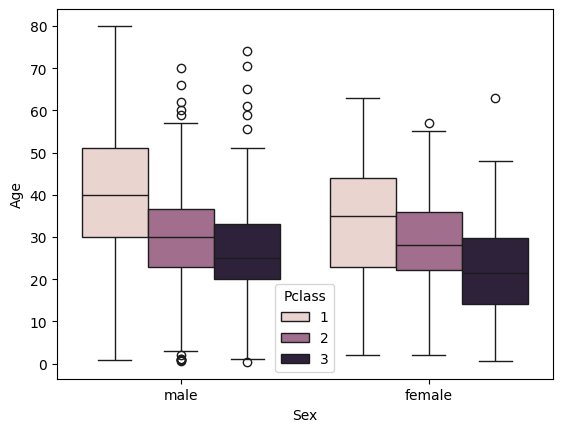

In [39]:
sns.boxplot(x="Sex", y="Age",hue ="Pclass", data=data)
plt.show()

Исходя из вышепредставленных результатов, можно сделать вывод, что незаписанный возраст у разных групп пассажиров - случайность, а стратегию заполнения пропущенных значений в столбце возраст можно выбрать - средний возраст для 1 и 2 групп и отдельно - средний возраст для 3 группы (по "ящику с усами", видно, что стат характеристики(медианы) довольно сильно отличаются)

In [40]:
mean_1_2 = data.loc[data['Pclass'].isin([1, 2]), 'Age'].mean()
mean_3 = data.loc[data['Pclass'] == 3, 'Age'].mean()

data.loc[(data['Pclass'].isin([1, 2])) & (data['Age'].isnull()), 'Age'] = mean_1_2
data.loc[(data['Pclass'] == 3) & (data['Age'].isnull()), 'Age'] = mean_3

In [41]:
mean_1_2 = X_train.loc[X_train['Pclass'].isin([1, 2]), 'Age'].mean()
mean_3 = X_train.loc[X_train['Pclass'] == 3, 'Age'].mean()

X_train.loc[(X_train['Pclass'].isin([1, 2])) & (X_train['Age'].isnull()), 'Age'] = mean_1_2
X_train.loc[(X_train['Pclass'] == 3) & (X_train['Age'].isnull()), 'Age'] = mean_3

###Cabin

Из 890 наблюдений в столбце Cabin пропущена большая часть, 687 значений, поэтому можно сделать вывод, что столбец Cabin не репрезентативен. Теперь есть смысл посмотреть, были ли пропуски случайностью или наличие одиночной кабины каким-то образом влияло на выживаемость

In [42]:
cabin_counts = data['Cabin'].value_counts()

Мы нашли все люди проезжавшие в неодиночных кабинах. Теперь создадим новый стобец IsSingle, где 1 - если человек ехал в одиночной кабине и 0 - если в  не одиночной

In [43]:
data['Is_Single'] = data['Cabin'].map(cabin_counts) == 1
data['Is_Single']

0      False
1       True
2      False
3      False
4      False
       ...  
886    False
887     True
888    False
889     True
890    False
Name: Is_Single, Length: 891, dtype: bool

Посмотрим как одиночная кабина влияла на выживаемость с помощью столбчатой диаграммы

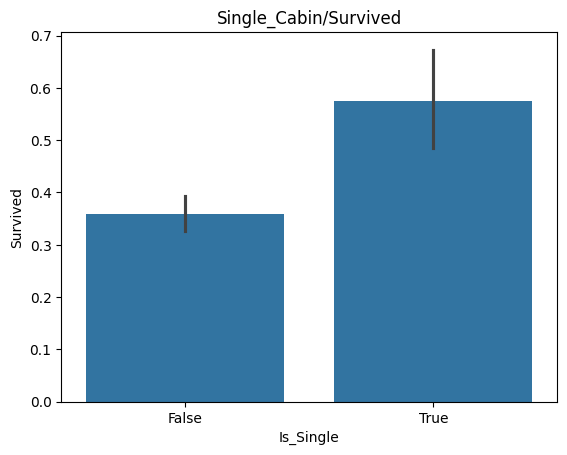

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots()

sns.barplot(data = data, x = 'Is_Single', y = 'Survived')
ax.set(title='Single_Cabin/Survived')

plt.show()

Можно заметить, что люди, которые путешествовали в одиночной кабине, были более склонны к выживанию, чем те, кто путешествовал вместе. Скорее всего, это связано с тем, что люди, путешествовавшие вместе были с детьми и в первую очередь садили в шлюпки детей, а потом уже задумывались о собственном выживании

Удалим столбец Cabin: он содержит слишком маленькое количество наблюдений

In [45]:
X_train = X_train.drop(['Cabin'], axis = 1)
X_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00000,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00000,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,25.14062,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00000,0,0,111369,30.0000,C


###Embarked

Остался единственный столбец - Embarked. Посмотрим, как он влиял на выживаемость. Закодируем данную переменную с помощью OneHotEncoding

In [46]:
data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Посмотрим, как порт, в котором сел пассажир, влияет на выживаемость

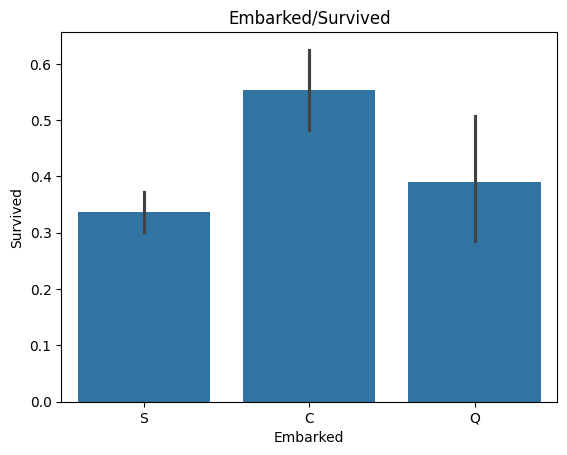

In [47]:
fig, ax = plt.subplots()

sns.barplot(data = data, x = 'Embarked', y = 'Survived')
ax.set(title='Embarked/Survived')

plt.show()

Видно, что пассажиры, севшие в порту Cherbourg, склонны к выживанию больше, чем пассажиры с других портов

Также посмотрим такую же зависимость для каждого из классов

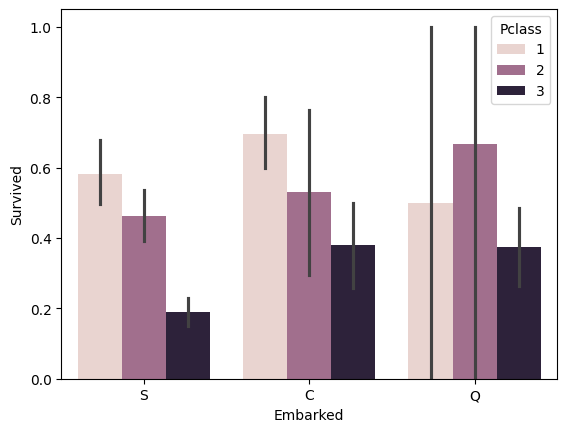

In [48]:
sns.barplot(data = data, x = 'Embarked', y = 'Survived', hue = 'Pclass')
ax.set(title='Embarked/Survived for Pclass')

plt.show()

Видно, что для порта Q выживших пассажиров из 2 класса было больше, чем для 1. Посмотрим, кем были эти люди(пол/возраст)

In [49]:
data_Q_survived = data[data['Embarked'] == 'Q'][data['Survived'] == 1]

<ipython-input-49-9995e176ca83>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_Q_survived = data[data['Embarked'] == 'Q'][data['Survived'] == 1]


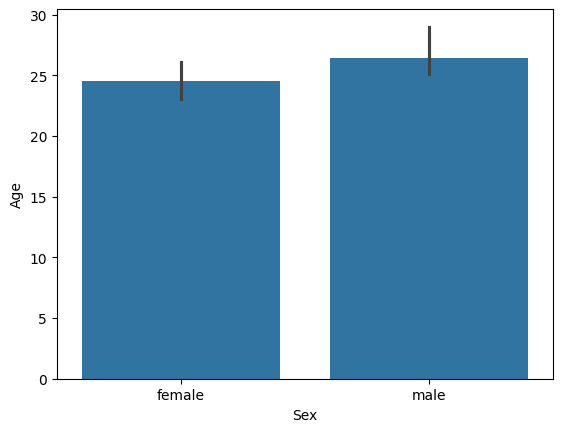

In [50]:
sns.barplot(data = data_Q_survived, x = 'Sex', y = 'Age')
ax.set(title='Sex and Age')

plt.show()

In [51]:
data_Q_survived[data_Q_survived['Sex'] == 'female']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_NaN,Is_Single
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.000000,0,0,330923,8.0292,NaN,Q,1,False
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,25.140620,0,0,330959,7.8792,NaN,Q,0,False
32,33,1,3,"Glynn, Miss. Mary Agatha",female,25.140620,0,0,335677,7.7500,NaN,Q,0,False
44,45,1,3,"Devaney, Miss. Margaret Delia",female,19.000000,0,0,330958,7.8792,NaN,Q,1,False
47,48,1,3,"O'Driscoll, Miss. Bridget",female,25.140620,0,0,14311,7.7500,NaN,Q,0,False
82,83,1,3,"McDermott, Miss. Brigdet Delia",female,25.140620,0,0,330932,7.7875,NaN,Q,0,False
109,110,1,3,"Moran, Miss. Bertha",female,25.140620,1,0,371110,24.1500,NaN,Q,0,False
156,157,1,3,"Gilnagh, Miss. Katherine ""Katie""",female,16.000000,0,0,35851,7.7333,NaN,Q,1,False
186,187,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,25.140620,1,0,370365,15.5000,NaN,Q,0,False
198,199,1,3,"Madigan, Miss. Margaret ""Maggie""",female,25.140620,0,0,370370,7.7500,NaN,Q,0,False


Из 30 пассажиров выжило всего 3 молодых мужчин из третьего класса, остальными были молодые женщины преимущественно из 3 класса

Теперь посмотрим на связь возраста пассажиров с портом, в котором они сели

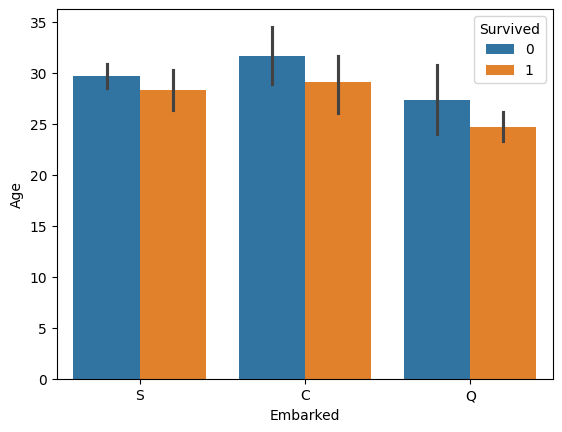

In [52]:
sns.barplot(data = data, x = 'Embarked', y = 'Age', hue = 'Survived')
ax.set(title='Embarked/Survived for Pclass')

plt.show()

Средний возраст пассажиров был примерно одинаков для каждого из портов

Можно сделать вывод, что выживаемость пассажиров зависела не столько от порта, в котором они сели, сколько от класса и пола, поэтому следующим шагом закодируем признак порта OneHot-кодированием и посмотрим какого пола и возраста и из какого класса чаще всего выживало пассажиров

In [53]:
X_train = pd.get_dummies(X_train, columns=["Embarked"], drop_first = True)

Проверим, остались ли в датасете пустые данные

In [54]:
data.isna().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
Age_NaN        False
Is_Single      False
dtype: bool

##Кто более склонен к выживанию?

Посмотрим зависимость пола и класса с выживаемостью

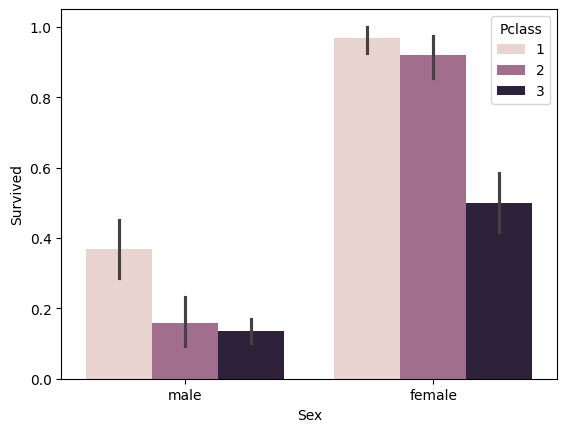

In [55]:
sns.barplot(data = data, x = 'Sex', y = 'Survived', hue = 'Pclass')
ax.set(title='Sex/Survived')

plt.show()

Видно, что женщин из 1-2 классов выживало значительно больше, чем других людей. Есть смысл посмотреть количество женщин в каждом из классов

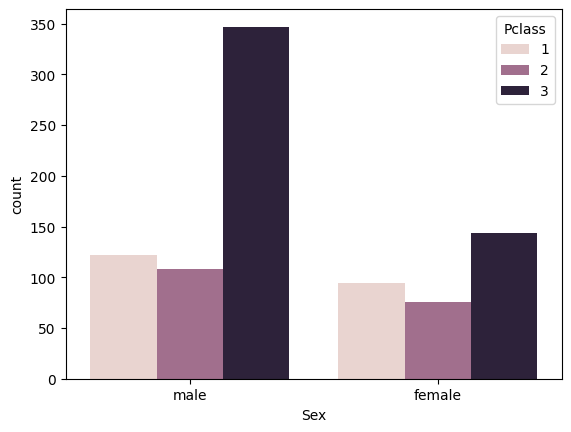

In [56]:
sns.countplot(data = data, x = 'Sex', hue = 'Pclass')
ax.set(title='Sex')

plt.show()

Количество мужчин и женщин в 1 и 2 классе примерно совпадает, в третьем же количество женщин в 3 раза меньше, чем мужчин, однако женщин выжило в 2 раза больше

Можно сделать **вывод**, что к выживанию склонны женщины и дети, первым приоритетом шли пассажиры с 1 класса, затем 2, и, окончательно, 3

# Кодирование категориальных переменных

Найдем все категориальные переменные датасета, создав маску


In [57]:
cat_features_mask = X_train.dtypes == 'object'
X_train.columns[cat_features_mask]

Index(['Name', 'Sex', 'Ticket'], dtype='object')

Колонка "Имя" не представляет для исследования особого значения, поэтому уберем ее

In [58]:
X_train = X_train.drop(columns=['Name'])

Колонку "Пол" мы закодируем с помощью бинарной переменной, которая принимает значение 1 для мужчин и 0 для женщин

In [59]:
X_train['Sex'] = np.where(X_train['Sex'] == 'male', 1, 0)
X_train

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_Q,Embarked_S
0,1,0,3,1,22.00000,1,0,A/5 21171,7.2500,0,1
1,2,1,1,0,38.00000,1,0,PC 17599,71.2833,0,0
2,3,1,3,0,26.00000,0,0,STON/O2. 3101282,7.9250,0,1
3,4,1,1,0,35.00000,1,0,113803,53.1000,0,1
4,5,0,3,1,35.00000,0,0,373450,8.0500,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,1,27.00000,0,0,211536,13.0000,0,1
887,888,1,1,0,19.00000,0,0,112053,30.0000,0,1
888,889,0,3,0,25.14062,1,2,W./C. 6607,23.4500,0,1
889,890,1,1,1,26.00000,0,0,111369,30.0000,0,0


Колонка "PassengerId" и "Ticket "также не представляют собой полезной информации

In [60]:
Pass_train = X_train['PassengerId']
X_train = X_train.drop(columns=['PassengerId'])

In [61]:
X_train = X_train.drop(columns=['Ticket'])

In [62]:
X_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,0,3,1,22.00000,1,0,7.2500,0,1
1,1,1,0,38.00000,1,0,71.2833,0,0
2,1,3,0,26.00000,0,0,7.9250,0,1
3,1,1,0,35.00000,1,0,53.1000,0,1
4,0,3,1,35.00000,0,0,8.0500,0,1
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.00000,0,0,13.0000,0,1
887,1,1,0,19.00000,0,0,30.0000,0,1
888,0,3,0,25.14062,1,2,23.4500,0,1
889,1,1,1,26.00000,0,0,30.0000,0,0


Совершим те же действия для тестовой выборки:

In [63]:
X_test = pd.get_dummies(test, columns=["Embarked"], drop_first = True)
X_test = X_test.drop(columns=['Name'])
X_test['Sex'] = np.where(X_test['Sex'] == 'male', 1, 0)
Pass_test = X_test['PassengerId']
X_test = X_test.drop(columns=['PassengerId'])
X_test = X_test.drop(columns=['Ticket'])
X_test = X_test.drop(columns=['Cabin'])

In [64]:
mean_1_2 = X_test.loc[X_test['Pclass'].isin([1, 2]), 'Age'].mean()
mean_3 = X_test.loc[X_test['Pclass'] == 3, 'Age'].mean()

X_test.loc[(X_test['Pclass'].isin([1, 2])) & (X_test['Age'].isnull()), 'Age'] = mean_1_2
X_test.loc[(X_test['Pclass'] == 3) & (X_test['Age'].isnull()), 'Age'] = mean_3

In [65]:
X_test['Fare'].isnull().value_counts()

False    417
True       1
Name: Fare, dtype: int64

В наблюдение, где отсутствует цена билета, занесем средню цену билета

In [66]:
mean_fare = X_test['Fare'].mean()
X_test['Fare'].fillna(mean_fare, inplace=True)

# Исследование признаков

In [70]:
from sklearn.preprocessing import StandardScaler

stdscl = StandardScaler()
X_train_std = stdscl.fit_transform(X_train)
X_test_std = stdscl.transform(X_test)

Построим матрицу корреляции Пирсона

In [73]:
X_train

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,3,1,22.00000,1,0,7.2500,0,1
1,1,0,38.00000,1,0,71.2833,0,0
2,3,0,26.00000,0,0,7.9250,0,1
3,1,0,35.00000,1,0,53.1000,0,1
4,3,1,35.00000,0,0,8.0500,0,1
...,...,...,...,...,...,...,...,...
886,2,1,27.00000,0,0,13.0000,0,1
887,1,0,19.00000,0,0,30.0000,0,1
888,3,0,25.14062,1,2,23.4500,0,1
889,1,1,26.00000,0,0,30.0000,0,0


<ipython-input-75-8de524f327d8>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),


<Axes: title={'center': 'Pearson Correlation of Features'}>

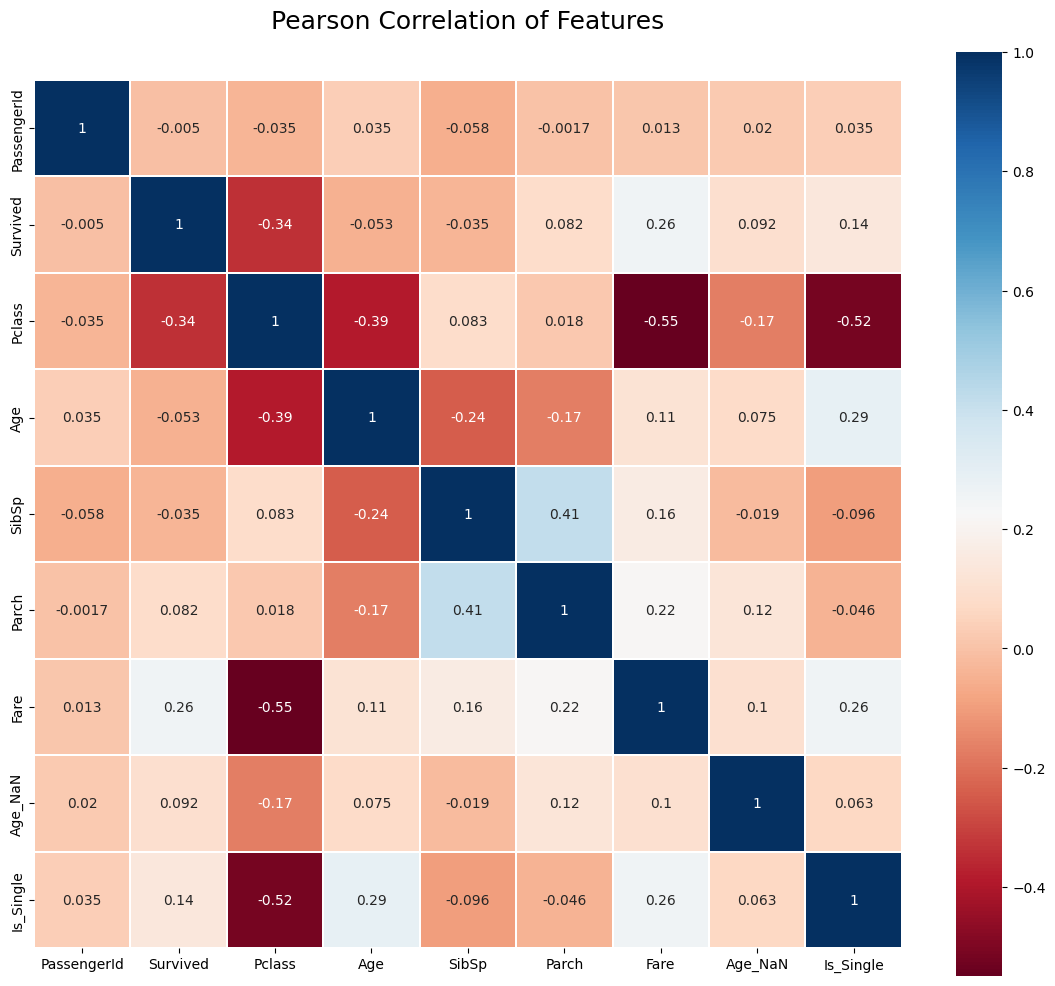

In [75]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))

plt.title('Pearson Correlation of Features', y=1.05, size=18)
sns.heatmap(data.corr(),
            linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

Из матрицы корреляций видно, что признаки Parch и SibSp слабо коррелируют с выживаемостью.